In [1]:
import pandas
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
import math
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.linear_model import Lasso

In [2]:
def get_outlier_indices(df, features):
    outlier_indices = []

    for c in features:
        Q1 = df[c].quantile(0.25)
        Q3 = df[c].quantile(0.75)
        IQR = Q3 - Q1

        outlier_step = 1.5 * IQR

        outlier_list_col = df[(df[c] < Q1 - outlier_step) | (df[c] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)

    outlier_indices = list(set(outlier_indices))
    return outlier_indices

def remove_outliers(df, features):
    outlier_indices = get_outlier_indices(df, features)
    df_cleaned = df.drop(outlier_indices)
    df_cleaned.reset_index(drop=True, inplace=True)
    return df_cleaned

In [3]:
df = pandas.read_csv('Clean_Dataset.csv')
columns_to_drop = ['Unnamed: 0', 'flight']
df = df.drop(columns=columns_to_drop)
le = LabelEncoder()
df.flight_class = df.flight_class.replace({'Economy' : 1,'Business' :2})
df['airline'] = le.fit_transform(df['airline'])
df['source_city'] = le.fit_transform(df['source_city'])
df['destination_city'] = le.fit_transform(df['destination_city'])
df['departure_time'] = le.fit_transform(df['departure_time'])
df['arrival_time'] = le.fit_transform(df['arrival_time'])
df['stops'] = le.fit_transform(df['stops'])
# # One-hot encoding
# columns_to_onehot = ['airline', 'source_city', 'destination_city', 'departure_time', 'arrival_time', 'stops']

# ohe = OneHotEncoder(drop='first', sparse_output=False)
# one_hot_encoded = ohe.fit_transform(df[columns_to_onehot])

# df_encoded = pandas.DataFrame(one_hot_encoded, columns=ohe.get_feature_names_out(columns_to_onehot))
# df = pandas.concat([df.drop(columns=columns_to_onehot), df_encoded], axis=1)
df = remove_outliers(df, ['duration', 'price'])
X = df.drop(columns='price')
y = df.price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

df_business = df[df['flight_class'] == 2]
X_business = df_business.drop(columns='price')
y_business = df_business.price
X_train_business, X_test_business, y_train_business, y_test_business = train_test_split(X_business, y_business, test_size=0.20, random_state=0)

df_economy = df[df['flight_class'] == 1]
X_economy = df_economy.drop(columns='price')
y_economy = df_economy.price
X_train_economy, X_test_economy, y_train_economy, y_test_economy = train_test_split(X_economy, y_economy, test_size=0.20, random_state=0)



C:\Users\Ivana\AppData\Local\Temp\ipykernel_23864\1441606978.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.flight_class = df.flight_class.replace({'Economy' : 1,'Business' :2})


## Linear regression

In [4]:
lr = LinearRegression().fit(X, y)
y_pred_lr = lr.predict(X_test)
mse_linear = metrics.mean_squared_error(y_test, y_pred_lr)
rmse_linear = math.sqrt(mse_linear)
mae_linear = metrics.mean_absolute_error(y_test, y_pred_lr)
print("MSE: " + str(mse_linear))
print("RMSE: " + str(rmse_linear))
print("MAE: " + str(mae_linear))

MSE: 48220128.129044436
RMSE: 6944.071437495761
MAE: 4635.282149073735


## Linear regression for business class

In [5]:
lr_business = LinearRegression().fit(X_business, y_business)
y_pred_lr_business = lr_business.predict(X_test_business)
mse_linear_b = metrics.mean_squared_error(y_test_business, y_pred_lr_business)
rmse_linear_b = math.sqrt(mse_linear_b)
mae_linear_b = metrics.mean_absolute_error(y_test_business, y_pred_lr_business)
print("MSE: " + str(mse_linear_b))
print("RMSE: " + str(rmse_linear_b))
print("MAE: " + str(mae_linear_b))

MSE: 94337423.44612947
RMSE: 9712.745412401659
MAE: 7376.578364521865


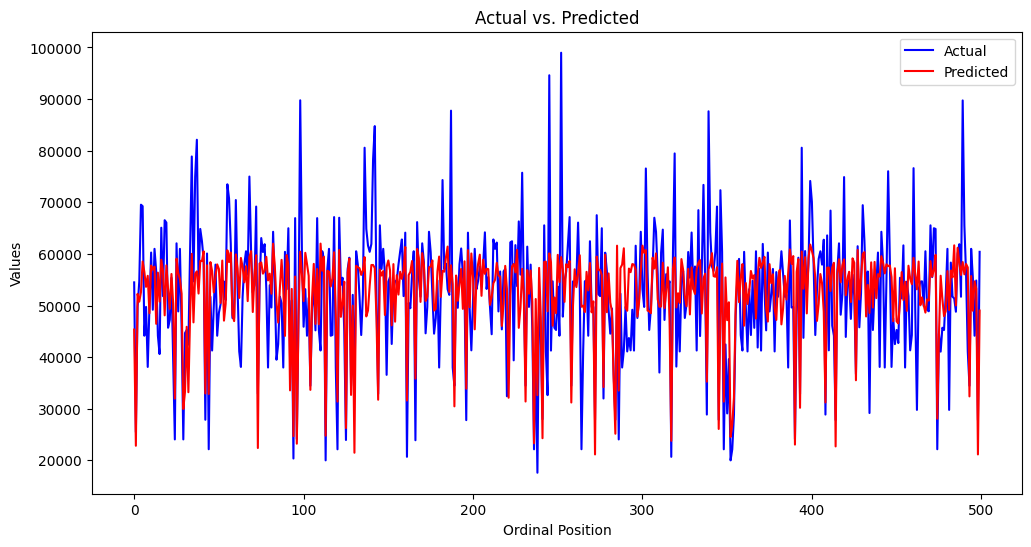

In [6]:
pred1 = pandas.DataFrame({"actual": y_test_business, 'predicted': y_pred_lr_business})
plt.figure(figsize=(12, 6))

plt.plot(range(len(pred1['actual'][:500])), pred1['actual'][:500], color='blue', label='Actual')
plt.plot(range(len(pred1['predicted'][:500])), pred1['predicted'][:500], color='red', label='Predicted')

plt.xlabel('Ordinal Position')
plt.ylabel('Values')
plt.title('Actual vs. Predicted')
plt.legend()
plt.show()

## Linear regression for economy class

In [7]:
lr_economy = LinearRegression().fit(X_economy, y_economy)
y_pred_lr_economy = lr_economy.predict(X_test_economy)
mse_linear_e = metrics.mean_squared_error(y_test_economy, y_pred_lr_economy)
rmse_linear_e = math.sqrt(mse_linear_e)
mae_linear_e = metrics.mean_absolute_error(y_test_economy, y_pred_lr_economy)
print("MSE: " + str(mse_linear_e))
print("RMSE: " + str(rmse_linear_e))
print("MAE: " + str(mae_linear_e))

MSE: 8168976.152494205
RMSE: 2858.1420805296234
MAE: 2065.8963861229067


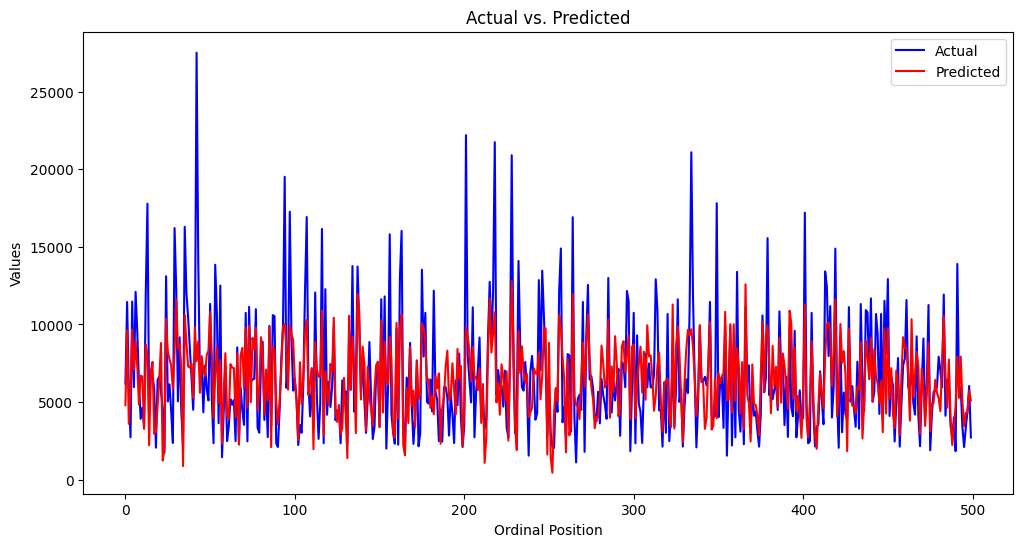

In [8]:
pred1 = pandas.DataFrame({"actual": y_test_economy, 'predicted': y_pred_lr_economy})
plt.figure(figsize=(12, 6))

plt.plot(range(len(pred1['actual'][:500])), pred1['actual'][:500], color='blue', label='Actual')
plt.plot(range(len(pred1['predicted'][:500])), pred1['predicted'][:500], color='red', label='Predicted')

plt.xlabel('Ordinal Position')
plt.ylabel('Values')
plt.title('Actual vs. Predicted')
plt.legend()
plt.show()

## Random forest

In [9]:
# param_grid = {
#     'n_estimators': [100, 200, 300, 400, 500],
#     'max_features': [2, 4, 6, 8],
# }
# rf = RandomForestRegressor(n_jobs=-1)
# grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
# grid_search.fit(X_train, y_train)
# best_params = grid_search.best_params_
# print(best_params)
final_rf = RandomForestRegressor(n_estimators=500, max_features=8, n_jobs=-1).fit(X_train, y_train)
y_pred_rf = final_rf.predict(X_test)
mse_rf = metrics.mean_squared_error(y_test, y_pred_rf)
rmse_rf = math.sqrt(mse_rf)
mae_rf = metrics.mean_absolute_error(y_test, y_pred_rf)

print("MSE:", mse_rf)
print("RMSE:", rmse_rf)
print("MAE:", mae_rf)

MSE: 7312354.434808571
RMSE: 2704.1365414506295
MAE: 1070.6520183976568


## Random forest for business class

In [10]:
# param_grid = {
#     'n_estimators': [100, 200, 300, 400, 500],
#     'max_features': [2, 4, 6, 8],
# }
# rf = RandomForestRegressor(n_jobs=-1)
# grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
# grid_search.fit(X_train_business, y_train_business)
# best_params = grid_search.best_params_
# print(best_params)
final_rf = RandomForestRegressor(n_estimators=500, max_features=8, n_jobs=-1).fit(X_train_business, y_train_business)
y_pred_rf_business = final_rf.predict(X_test_business)
mse_rf_b = metrics.mean_squared_error(y_test_business, y_pred_rf_business)
rmse_rf_b = math.sqrt(mse_rf_b)
mae_rf_b = metrics.mean_absolute_error(y_test_business, y_pred_rf_business)

print("MSE:", mse_rf_b)
print("RMSE:", rmse_rf_b)
print("MAE:", mae_rf_b)

MSE: 18853221.331558455
RMSE: 4342.0296327361075
MAE: 2053.8257435008068


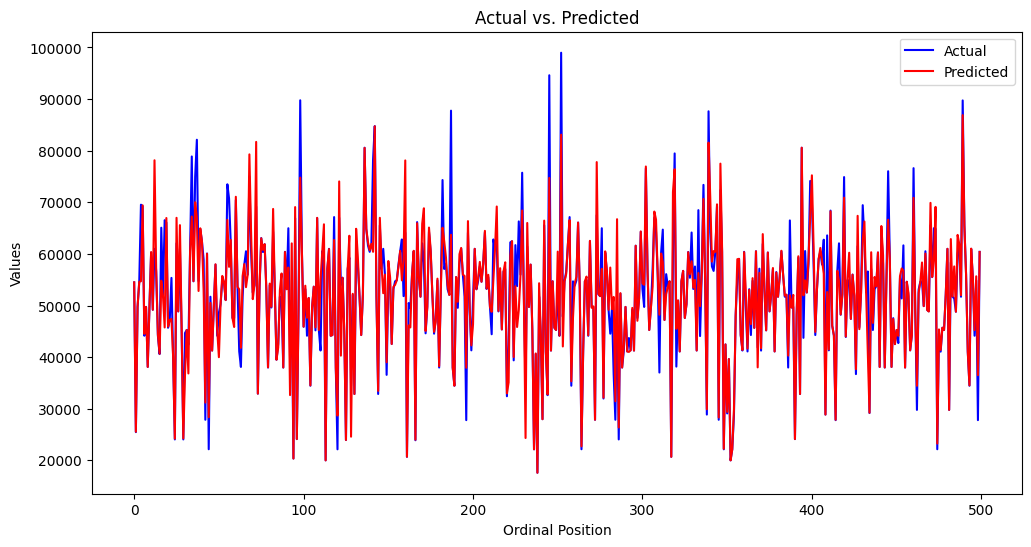

In [11]:
pred1 = pandas.DataFrame({"actual": y_test_business, 'predicted': y_pred_rf_business})
plt.figure(figsize=(12, 6))

plt.plot(range(len(pred1['actual'][:500])), pred1['actual'][:500], color='blue', label='Actual')
plt.plot(range(len(pred1['predicted'][:500])), pred1['predicted'][:500], color='red', label='Predicted')

plt.xlabel('Ordinal Position')
plt.ylabel('Values')
plt.title('Actual vs. Predicted')
plt.legend()
plt.show()

## Random forest for economy class

In [12]:
# param_grid = {
#     'n_estimators': [100, 200, 300, 400, 500],
#     'max_features': [2, 4, 6, 8],
# }
# rf = RandomForestRegressor(n_jobs=-1)
# grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
# grid_search.fit(X_train_economy, y_train_economy)
# best_params = grid_search.best_params_
# print(best_params)
final_rf = RandomForestRegressor(n_estimators=500, max_features=8, n_jobs=-1).fit(X_train_economy, y_train_economy)
y_pred_rf = final_rf.predict(X_test_economy)
mse_rf_e = metrics.mean_squared_error(y_test_economy, y_pred_rf)
rmse_rf_e = math.sqrt(mse_rf_e)
mae_rf_e = metrics.mean_absolute_error(y_test_economy, y_pred_rf)

print("MSE:", mse_rf_e)
print("RMSE:", rmse_rf_e)
print("MAE:", mae_rf_e)

MSE: 1908111.6380606021
RMSE: 1381.3441417911042
MAE: 614.3670684035371


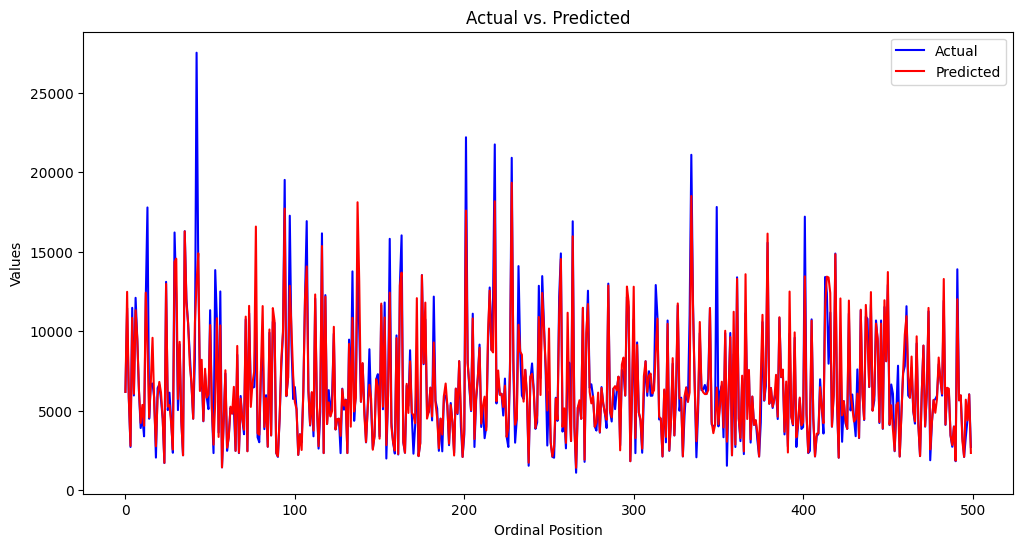

In [13]:
pred1 = pandas.DataFrame({"actual": y_test_economy, 'predicted': y_pred_rf})
plt.figure(figsize=(12, 6))

plt.plot(range(len(pred1['actual'][:500])), pred1['actual'][:500], color='blue', label='Actual')
plt.plot(range(len(pred1['predicted'][:500])), pred1['predicted'][:500], color='red', label='Predicted')

plt.xlabel('Ordinal Position')
plt.ylabel('Values')
plt.title('Actual vs. Predicted')
plt.legend()
plt.show()

## Multilayer Perceptron

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import models, layers
from sklearn.metrics import mean_squared_error
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = models.Sequential()

# param_grid = {
#     'neurons1': [64, 128, 256],
#     'neurons2': [32, 64, 128],
#     'activation': ['relu', 'tanh', 'sigmoid'],
# }

# grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
# grid_search_result = grid_search.fit(X_train_scaled, y_train)
# best_params = grid_search_result.best_params_
# print(best_params)

model.add(layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_loss, mae_mp = model.evaluate(X_test_scaled, y_test)
print(f'Test MAE: {mae_mp}')

y_pred = model.predict(X_test_scaled)

# Calculate and print MSE and RMSE
mse_mp = mean_squared_error(y_test, y_pred)
rmse_mp = np.sqrt(mse_mp)

print(f'Test MSE: {mse_mp}')
print(f'Test RMSE: {rmse_mp}')

C:\Users\Ivana\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
5959/5959 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 315410880.0000 - mae: 9868.4355 - val_loss: 36127996.0000 - val_mae: 3731.4885
Epoch 2/10
5959/5959 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 35259148.0000 - mae: 3676.2634 - val_loss: 35088832.0000 - val_mae: 3618.9409
Epoch 3/10
5959/5959 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 34404340.0000 - mae: 3593.6292 - val_loss: 34964288.0000 - val_mae: 3584.6682
Epoch 4/10
5959/5959 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 34080936.0000 - mae: 3573.4204 - val_loss: 34634440.0000 - val_mae: 3579.4414
Epoch 5/10
5959/5959 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 33506400.0000 - mae: 3540.8943 - val_loss: 34304796.0000 - val_mae: 3567.3301
Epoch 6/10
5959/5959 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 33628668.0000 - mae: 3546.8875 - val_loss: 33943436.0000 - val_mae: 3535.6204
Epoch 7/10
5959/5959 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 33025018.0000 - mae: 3517.5637 - val_loss: 33388898.0000 - val_mae: 3529.9448
Epoch 8/10
5

## Multilayer Perceptron for business class

In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_business)
X_test_scaled = scaler.transform(X_test_business)

model = models.Sequential()

# param_grid = {
#     'neurons1': [64, 128, 256],
#     'neurons2': [32, 64, 128],
#     'activation': ['relu', 'tanh', 'sigmoid'],
# }

# grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
# grid_search_result = grid_search.fit(X_train_scaled, y_train_business)
# best_params = grid_search_result.best_params_
# print(best_params)

model.add(layers.Dense(128, activation='relu', input_shape=(X_train_business.shape[1],)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.fit(X_train_scaled, y_train_business, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_loss, mae_mp_b = model.evaluate(X_test_scaled, y_test_business)
print(f'Test MAE: {mae_mp_b}')

y_pred = model.predict(X_test_scaled)

# Calculate and print MSE and RMSE
mse_mp_b = mean_squared_error(y_test_business, y_pred)
rmse_mp_b = np.sqrt(mse_mp_b)

print(f'Test MSE: {mse_mp_b}')
print(f'Test RMSE: {rmse_mp_b}')

Epoch 1/10


C:\Users\Ivana\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1863/1863 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 2148877056.0000 - mae: 42519.7539 - val_loss: 114923224.0000 - val_mae: 7799.6582
Epoch 2/10
1863/1863 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 109909256.0000 - mae: 7636.1284 - val_loss: 102297560.0000 - val_mae: 7382.1221
Epoch 3/10
1863/1863 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 99969272.0000 - mae: 7313.6372 - val_loss: 95783584.0000 - val_mae: 7189.2358
Epoch 4/10
1863/1863 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 92817960.0000 - mae: 7118.4966 - val_loss: 92263344.0000 - val_mae: 7080.4443
Epoch 5/10
1863/1863 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 91031304.0000 - mae: 7080.4868 - val_loss: 90324312.0000 - val_mae: 7022.0439
Epoch 6/10
1863/1863 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 89896744.0000 - mae: 7037.3784 - val_loss: 88978984.0000 - val_mae: 6987.0586
Epoch 7/10
1863/1863 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 87962760.0000 - mae: 6965.7783 - val_loss: 88178248.0000 - val_mae: 6971.2998
Epoch 8/10
1863/1863 ━━━━

## Multilayer Perceptron for economy class

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_economy)
X_test_scaled = scaler.transform(X_test_economy)

model = models.Sequential()

# param_grid = {
#     'neurons1': [64, 128, 256],
#     'neurons2': [32, 64, 128],
#     'activation': ['relu', 'tanh', 'sigmoid'],
# }

# grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
# grid_search_result = grid_search.fit(X_train_scaled, y_train_economy)
# best_params = grid_search_result.best_params_
# print(best_params)

model.add(layers.Dense(128, activation='relu', input_shape=(X_train_economy.shape[1],)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.fit(X_train_scaled, y_train_economy, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_loss, mae_mp_e = model.evaluate(X_test_scaled, y_test_economy)
print(f'Test MAE: {mae_mp_e}')

y_pred = model.predict(X_test_scaled)

# Calculate and print MSE and RMSE
mse_mp_e = mean_squared_error(y_test_economy, y_pred)
rmse_mp_e = np.sqrt(mse_mp_e)

print(f'Test MSE: {mse_mp_e}')
print(f'Test RMSE: {rmse_mp_e}')

Epoch 1/10


C:\Users\Ivana\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4096/4096 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 23063516.0000 - mae: 3505.5864 - val_loss: 7348042.0000 - val_mae: 1938.6932
Epoch 2/10
4096/4096 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 7176598.0000 - mae: 1902.1396 - val_loss: 6554838.5000 - val_mae: 1805.6760
Epoch 3/10
4096/4096 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 6575757.5000 - mae: 1798.0981 - val_loss: 6410346.5000 - val_mae: 1777.0029
Epoch 4/10
4096/4096 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 6400232.5000 - mae: 1771.0118 - val_loss: 6318642.5000 - val_mae: 1761.0366
Epoch 5/10
4096/4096 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 6391987.5000 - mae: 1755.6064 - val_loss: 6248789.0000 - val_mae: 1740.6244
Epoch 6/10
4096/4096 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 6311904.5000 - mae: 1746.2340 - val_loss: 6213557.0000 - val_mae: 1745.6227
Epoch 7/10
4096/4096 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 6241139.0000 - mae: 1732.4438 - val_loss: 6143363.0000 - val_mae: 1727.8436
Epoch 8/10
4096/4096 ━━━━━━━━━━━━━━━━━━━━ 8

## Bagging Regression Tree

In [17]:
base_regressor = DecisionTreeRegressor(random_state=42)

# Create a Bagging Regressor with Decision Trees as base estimators
bagging_regressor = BaggingRegressor(base_regressor, n_estimators=10, random_state=42)

# Define the parameter grid for hyperparameter tuning
# param_grid = {
#     'n_estimators': [5, 10, 15],
#     'max_samples': [0.5, 0.7, 1.0],
#     'max_features': [0.5, 0.7, 1.0]
# }

# # Use GridSearchCV for hyperparameter tuning
# grid_search = GridSearchCV(bagging_regressor, param_grid, cv=5, scoring='neg_mean_squared_error')
# tree_bg = grid_search.fit(X_train, y_train)

# parameters = {
#     'splitter' : ['best', 'random'],
#     'max_features' : [None, 8, 7, 6, 5],
# }


# tree = DecisionTreeRegressor()
# tree_cv = GridSearchCV(estimator=tree, param_grid=parameters, cv=20).fit(X_train, y_train)

tree = DecisionTreeRegressor(splitter='best',max_features=None)
bagging_regressor = BaggingRegressor(base_regressor,n_estimators=15,max_samples=0.5,max_features=1.0, random_state=42)
# Fit the Bagging Regressor on the training data
bagging_regressor.fit(X_train, y_train)
y_pred = bagging_regressor.predict(X_test)

mse_bagging = metrics.mean_squared_error(y_test, y_pred)
rmse_bagging = math.sqrt(mse_bagging)
mae_bagging = metrics.mean_absolute_error(y_test, y_pred)
print("MSE: " + str(mse_bagging))
print("RMSE: " + str(rmse_bagging))
print("MAE: " + str(mae_bagging))

MSE: 7295633.8596384935
RMSE: 2701.043105846053
MAE: 1145.898434661537


## Bagging Regression Tree for economy class

In [18]:
base_regressor = DecisionTreeRegressor(random_state=42)

# Create a Bagging Regressor with Decision Trees as base estimators
bagging_regressor = BaggingRegressor(base_regressor, n_estimators=10, random_state=42)

# Define the parameter grid for hyperparameter tuning
# param_grid = {
#     'n_estimators': [5, 10, 15],
#     'max_samples': [0.5, 0.7, 1.0],
#     'max_features': [0.5, 0.7, 1.0]
# }

# # Use GridSearchCV for hyperparameter tuning
# grid_search = GridSearchCV(bagging_regressor, param_grid, cv=5, scoring='neg_mean_squared_error')
# tree_bg = grid_search.fit(X_train_economy, y_train_economy)

# parameters = {
#     'splitter' : ['best', 'random'],
#     'max_features' : [None, 8, 7, 6, 5],
# }


# tree = DecisionTreeRegressor()
# tree_cv = GridSearchCV(estimator=tree, param_grid=parameters, cv=20).fit(X_train, y_train)

tree = DecisionTreeRegressor(splitter='best',max_features=None)
bagging_regressor = BaggingRegressor(base_regressor,n_estimators=15,max_samples=0.5,max_features=1.0, random_state=42)
# Fit the Bagging Regressor on the training data
bagging_regressor.fit(X_train_economy, y_train_economy)
y_pred = bagging_regressor.predict(X_test_economy)

mse_bagging_e = metrics.mean_squared_error(y_test_economy, y_pred)
rmse_bagging_e = math.sqrt(mse_bagging_e)
mae_bagging_e = metrics.mean_absolute_error(y_test_economy, y_pred)
print("MSE: " + str(mse_bagging_e))
print("RMSE: " + str(rmse_bagging_e))
print("MAE: " + str(mae_bagging_e))

MSE: 2124165.593711857
RMSE: 1457.451746615255
MAE: 690.2617504961406


## Bagging Regression Tree for business class

In [19]:
base_regressor = DecisionTreeRegressor(random_state=42)

# Create a Bagging Regressor with Decision Trees as base estimators
bagging_regressor = BaggingRegressor(base_regressor, n_estimators=10, random_state=42)

# Define the parameter grid for hyperparameter tuning
# param_grid = {
#     'n_estimators': [5, 10, 15],
#     'max_samples': [0.5, 0.7, 1.0],
#     'max_features': [0.5, 0.7, 1.0]
# }

# # Use GridSearchCV for hyperparameter tuning
# grid_search = GridSearchCV(bagging_regressor, param_grid, cv=5, scoring='neg_mean_squared_error')
# tree_bg = grid_search.fit(X_train_business, y_train_business)

# parameters = {
#     'splitter' : ['best', 'random'],
#     'max_features' : [None, 8, 7, 6, 5],
# }


# tree = DecisionTreeRegressor()
# tree_cv = GridSearchCV(estimator=tree, param_grid=parameters, cv=20).fit(X_train, y_train)

tree = DecisionTreeRegressor(splitter='best',max_features=None)
bagging_regressor = BaggingRegressor(base_regressor,n_estimators=15,max_samples=0.5,max_features=1.0, random_state=42)
# Fit the Bagging Regressor on the training data
bagging_regressor.fit(X_train_business, y_train_business)
y_pred = bagging_regressor.predict(X_test_business)

mse_bagging_b = metrics.mean_squared_error(y_test_business, y_pred)
rmse_bagging_b = math.sqrt(mse_bagging_b)
mae_bagging_b = metrics.mean_absolute_error(y_test_business, y_pred)
print("MSE: " + str(mse_bagging_b))
print("RMSE: " + str(rmse_bagging_b))
print("MAE: " + str(mae_bagging_b))

MSE: 18615411.670074083
RMSE: 4314.55810832049
MAE: 2161.473036317215


## SVM Regression

In [20]:
svr = SVR(kernel='linear', C=100, epsilon=0.3, gamma='scale')

# param_grid = {
#     'kernel': ['linear', 'poly', 'rbf'],  
#     'C': [0.1, 1, 10],
#     'gamma': ['scale', 'auto'],
#     'epsilon': [0.1, 0.2, 0.3]
# }

# grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
# grid_search.fit(X_train, y_train)
# best_svr = grid_search.best_estimator_

svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)

mse_svm = metrics.mean_squared_error(y_test, y_pred)
rmse_svm = np.sqrt(mse_svm)
mae_svm = metrics.mean_absolute_error(y_test, y_pred)

print("Mean Squared Error (MSE):", mse_svm)
print("Root Mean Squared Error (RMSE):", rmse_svm)
print("Mean Absolute Error (MAE):", mae_svm)

Mean Squared Error (MSE): 51650167.53273776
Root Mean Squared Error (RMSE): 7186.805099120037
Mean Absolute Error (MAE): 4276.208445676003


## SVM Regression - economy class

In [21]:
svr = SVR(kernel='linear', C=100, epsilon=0.3, gamma='scale')

svr.fit(X_train_economy, y_train_economy)
y_pred_economy = svr.predict(X_test_economy)

mse_svm_e = metrics.mean_squared_error(y_test_economy, y_pred_economy)
rmse_svm_e = np.sqrt(mse_svm_e)
mae_svm_e = metrics.mean_absolute_error(y_test_economy, y_pred_economy)

print("Mean Squared Error (MSE):", mse_svm_e)
print("Root Mean Squared Error (RMSE):", rmse_svm_e)
print("Mean Absolute Error (MAE):", mae_svm_e)

Mean Squared Error (MSE): 8645721.552161017
Root Mean Squared Error (RMSE): 2940.360786053476
Mean Absolute Error (MAE): 1999.786528401832


## SVM Regression - business class

In [22]:
svr = SVR(kernel='linear', C=100, epsilon=0.3, gamma='scale')

svr.fit(X_train_business, y_train_business)
y_pred_business = svr.predict(X_test_business)

mse_svm_b = metrics.mean_squared_error(y_test_business, y_pred_business)
rmse_svm_b = np.sqrt(mse_svm_b)
mae_svm_b = metrics.mean_absolute_error(y_test_business, y_pred_business)

print("Mean Squared Error (MSE):", mse_svm_b)
print("Root Mean Squared Error (RMSE):", rmse_svm_b)
print("Mean Absolute Error (MAE):", mae_svm_b)

Mean Squared Error (MSE): 95282822.70954612
Root Mean Squared Error (RMSE): 9761.292061481723
Mean Absolute Error (MAE): 7354.831906016623


## Lasso Regression

In [23]:
lasso = Lasso(alpha=0.1)

lasso.fit(X_train, y_train)

y_pred = lasso.predict(X_test)

mse_lasso = metrics.mean_squared_error(y_test, y_pred)
rmse_lasso = np.sqrt(mse_lasso)
mae_lasso = metrics.mean_absolute_error(y_test, y_pred)

print("Mean Squared Error (MSE):", mse_lasso)
print("Root Mean Squared Error (RMSE):", rmse_lasso)
print("Mean Absolute Error (MAE):", mae_lasso)

Mean Squared Error (MSE): 48223067.00276563
Root Mean Squared Error (RMSE): 6944.283044545753
Mean Absolute Error (MAE): 4635.835076771084


## Lasso Regression - economy class

In [24]:
lasso = Lasso(alpha=0.1)

lasso.fit(X_train_economy, y_train_economy)

y_pred_economy = lasso.predict(X_test_economy)

mse_lasso_e = metrics.mean_squared_error(y_test_economy, y_pred_economy)
rmse_lasso_e = np.sqrt(mse_lasso_e)
mae_lasso_e = metrics.mean_absolute_error(y_test_economy, y_pred_economy)

print("Mean Squared Error (MSE):", mse_lasso_e)
print("Root Mean Squared Error (RMSE):", rmse_lasso_e)
print("Mean Absolute Error (MAE):", mae_lasso_e)

Mean Squared Error (MSE): 8169476.536223177
Root Mean Squared Error (RMSE): 2858.2296157277456
Mean Absolute Error (MAE): 2066.203967260005


## Lasso Regression - business class

In [25]:
lasso = Lasso(alpha=0.1)

lasso.fit(X_train_business, y_train_business)

y_pred_business = lasso.predict(X_test_business)

mse_lasso_b = metrics.mean_squared_error(y_test_business, y_pred_business)
rmse_lasso_b = np.sqrt(mse_lasso_b)
mae_lasso_b = metrics.mean_absolute_error(y_test_business, y_pred_business)

print("Mean Squared Error (MSE):", mse_lasso_b)
print("Root Mean Squared Error (RMSE):", rmse_lasso_b)
print("Mean Absolute Error (MAE):", mae_lasso_b)

Mean Squared Error (MSE): 94354691.91864127
Root Mean Squared Error (RMSE): 9713.634331116304
Mean Absolute Error (MAE): 7375.977990869461


## XGBoost

In [26]:
XGB = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators = 10, seed = 42)

XGB.fit(X_train, y_train)
y_pred = XGB.predict(X_test)

mse_xg = metrics.mean_squared_error(y_test, y_pred)
rmse_xg = np.sqrt(mse_xg)
mae_xg = metrics.mean_absolute_error(y_test, y_pred)

print("Mean Squared Error (MSE):", mse_xg)
print("Root Mean Squared Error (RMSE):", rmse_xg)
print("Mean Absolute Error (MAE):", mae_xg)

Mean Squared Error (MSE): 21403580.13668307
Root Mean Squared Error (RMSE): 4626.400343321259
Mean Absolute Error (MAE): 2784.7580908376854


## XGBoost - economy class

In [27]:
XGB = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators = 10, seed = 42)

XGB.fit(X_train_economy, y_train_economy)
y_pred_economy = XGB.predict(X_test_economy)

mse_xg_e = metrics.mean_squared_error(y_test_economy, y_pred_economy)
rmse_xg_e = np.sqrt(mse_xg_e)
mae_xg_e = metrics.mean_absolute_error(y_test_economy, y_pred_economy)

print("Mean Squared Error (MSE):", mse_xg_e)
print("Root Mean Squared Error (RMSE):", rmse_xg_e)
print("Mean Absolute Error (MAE):", mae_xg_e)

Mean Squared Error (MSE): 4050836.9119947217
Root Mean Squared Error (RMSE): 2012.6691014656935
Mean Absolute Error (MAE): 1275.0522320177695


## XGBoost - business class

In [28]:
XGB = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators = 10, seed = 42)

XGB.fit(X_train_business, y_train_business)
y_pred_business = XGB.predict(X_test_business)

mse_xg_b = metrics.mean_squared_error(y_test_business, y_pred_business)
rmse_xg_b = np.sqrt(mse_xg_b)
mae_xg_b = metrics.mean_absolute_error(y_test_business, y_pred_business)

print("Mean Squared Error (MSE):", mse_xg_b)
print("Root Mean Squared Error (RMSE):", rmse_xg_b)
print("Mean Absolute Error (MAE):", mae_xg_b)

Mean Squared Error (MSE): 53399375.063616574
Root Mean Squared Error (RMSE): 7307.487602700163
Mean Absolute Error (MAE): 5407.51416770618


## Results for whole dataset

In [29]:
data = { 'Algorithm': ['Linear Regression', 'Random Forest', 'Multilayer Perceptron', 'Bagging Regression Tree', 'SVM Regression', 'Lasso Regression', 'XGBoost'],
         'MSE':[8168976, 7311588, 19842597, 7295633,51650167,48223067,21403580],
         'RMSE':[2858, 2703, 4454, 2701,7186,6944,4626],
               'MAE':[2065, 1070, 2627, 1145,4276,4635,2784]}
dataframe = pandas.DataFrame(data)
print(dataframe.to_string(index=False))

              Algorithm      MSE  RMSE  MAE
      Linear Regression  8168976  2858 2065
          Random Forest  7311588  2703 1070
  Multilayer Perceptron 19842597  4454 2627
Bagging Regression Tree  7295633  2701 1145
         SVM Regression 51650167  7186 4276
       Lasso Regression 48223067  6944 4635
                XGBoost 21403580  4626 2784


## Results for business class

In [30]:
data = { 'Algorithm': ['Linear Regression', 'Random Forest', 'Multilayer Perceptron', 'Bagging Regression Tree', 'SVM Regression', 'Lasso Regression', 'XGBoost'],
         'MSE':[94337423, 18960993, 85973699, 18615411,95282822,94354691,53399375],
         'RMSE':[9712, 4354, 9272, 4314,9761,9713,7307],
         'MAE':[7376, 2059, 6884, 2161,7354,7375,5407]}
dataframe = pandas.DataFrame(data)
print(dataframe.to_string(index=False))

              Algorithm      MSE  RMSE  MAE
      Linear Regression 94337423  9712 7376
          Random Forest 18960993  4354 2059
  Multilayer Perceptron 85973699  9272 6884
Bagging Regression Tree 18615411  4314 2161
         SVM Regression 95282822  9761 7354
       Lasso Regression 94354691  9713 7375
                XGBoost 53399375  7307 5407


## Results for economy class

In [31]:
data = { 'Algorithm': ['Linear Regression', 'Random Forest', 'Multilayer Perceptron', 'Bagging Regression Tree', 'SVM Regression', 'Lasso Regression', 'XGBoost'],
         'MSE':[8168976, 1908115, 5618096, 2028511,8645721,8169476,4050836],
         'RMSE':[2858, 1381, 2370, 1424,2940,2858,2012],
         'MAE':[2065, 614, 1623, 627,1999,2066,1275]}
dataframe = pandas.DataFrame(data)
print(dataframe.to_string(index=False))

              Algorithm     MSE  RMSE  MAE
      Linear Regression 8168976  2858 2065
          Random Forest 1908115  1381  614
  Multilayer Perceptron 5618096  2370 1623
Bagging Regression Tree 2028511  1424  627
         SVM Regression 8645721  2940 1999
       Lasso Regression 8169476  2858 2066
                XGBoost 4050836  2012 1275


## MSE

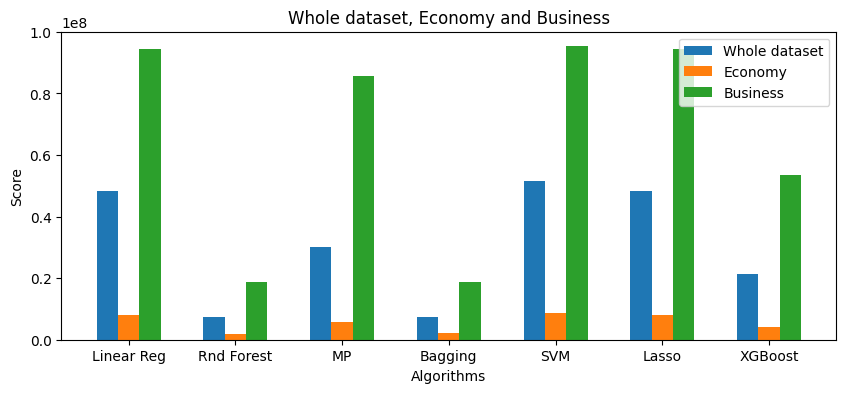

In [38]:
algorithms = ['Linear Reg', 'Rnd Forest', 'MP', 'Bagging', 'SVM', 'Lasso', 'XGBoost']
whole_dataset = [ mse_linear, 
                    mse_rf, 
                    mse_mp, 
                    mse_bagging, 
                    mse_svm, 
                    mse_lasso,
                    mse_xg]
economy_subset = [ mse_linear_e, 
                    mse_rf_e,
                    mse_mp_e, 
                    mse_bagging_e, 
                    mse_svm_e, 
                    mse_lasso_e,
                    mse_xg_e ]
business_subset = [ mse_linear_b, 
                    mse_rf_b, 
                    mse_mp_b, 
                    mse_bagging_b, 
                    mse_svm_b, 
                    mse_lasso_b,
                    mse_xg_b ]

fig, ax = plt.subplots(figsize=(10,4))
bar_width = 0.2
x_pos = np.arange(len(algorithms))

ax.bar(x_pos, whole_dataset, width=bar_width, label='Whole dataset')
ax.bar(x_pos + bar_width, economy_subset, width=bar_width, label='Economy')
ax.bar(x_pos + 2*bar_width, business_subset, width=bar_width, label='Business')

ax.set_xlabel('Algorithms')
ax.set_ylabel('Score')
ax.set_title('Whole dataset, Economy and Business')

ax.set_xticks(x_pos + bar_width)
ax.set_xticklabels(algorithms)

ax.legend()

plt.show()

## RMSE

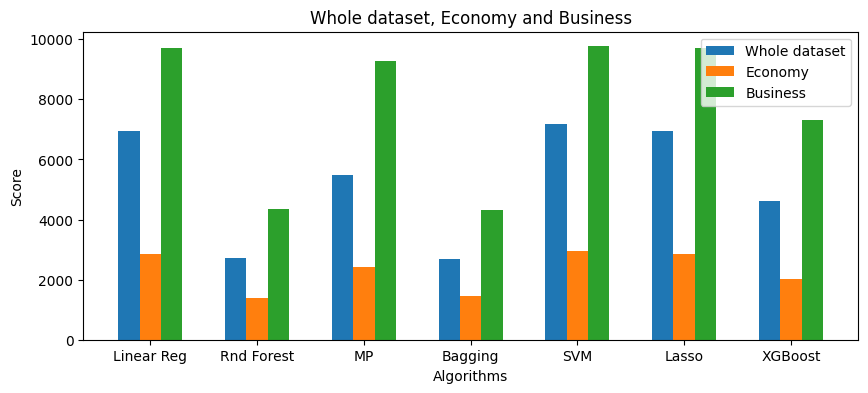

In [34]:
whole_dataset = [ rmse_linear, 
                    rmse_rf, 
                    rmse_mp, 
                    rmse_bagging, 
                    rmse_svm, 
                    rmse_lasso,
                    rmse_xg]
economy_subset = [ rmse_linear_e, 
                    rmse_rf_e,
                    rmse_mp_e, 
                    rmse_bagging_e, 
                    rmse_svm_e, 
                    rmse_lasso_e,
                    rmse_xg_e ]
business_subset = [ rmse_linear_b, 
                    rmse_rf_b, 
                    rmse_mp_b, 
                    rmse_bagging_b, 
                    rmse_svm_b, 
                    rmse_lasso_b,
                    rmse_xg_b ]

fig, ax = plt.subplots(figsize=(10,4))
bar_width = 0.2
x_pos = np.arange(len(algorithms))

ax.bar(x_pos, whole_dataset, width=bar_width, label='Whole dataset')
ax.bar(x_pos + bar_width, economy_subset, width=bar_width, label='Economy')
ax.bar(x_pos + 2*bar_width, business_subset, width=bar_width, label='Business')

ax.set_xlabel('Algorithms')
ax.set_ylabel('Score')
ax.set_title('Whole dataset, Economy and Business')

ax.set_xticks(x_pos + bar_width)
ax.set_xticklabels(algorithms)

ax.legend()

plt.show()

## MAE

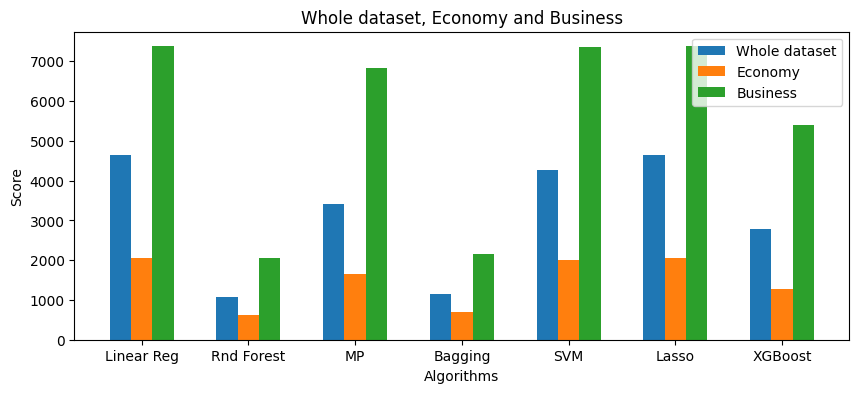

In [36]:
whole_dataset = [ mae_linear, 
                    mae_rf, 
                    mae_mp, 
                    mae_bagging, 
                    mae_svm, 
                    mae_lasso,
                    mae_xg]
economy_subset = [ mae_linear_e, 
                    mae_rf_e,
                    mae_mp_e, 
                    mae_bagging_e, 
                    mae_svm_e, 
                    mae_lasso_e,
                    mae_xg_e ]
business_subset = [ mae_linear_b, 
                    mae_rf_b, 
                    mae_mp_b, 
                    mae_bagging_b, 
                    mae_svm_b, 
                    mae_lasso_b,
                    mae_xg_b ]

fig, ax = plt.subplots(figsize=(10,4))
bar_width = 0.2
x_pos = np.arange(len(algorithms))

ax.bar(x_pos, whole_dataset, width=bar_width, label='Whole dataset')
ax.bar(x_pos + bar_width, economy_subset, width=bar_width, label='Economy')
ax.bar(x_pos + 2*bar_width, business_subset, width=bar_width, label='Business')

ax.set_xlabel('Algorithms')
ax.set_ylabel('Score')
ax.set_title('Whole dataset, Economy and Business')

ax.set_xticks(x_pos + bar_width)
ax.set_xticklabels(algorithms)

ax.legend()

plt.show()